# Sizing of locked token deals - how much to short at entry (t0)?
This notebook analyses the payoff schemes with a different ratios of short and long leg for token deals (i.e. deals entered into with discount). The objective is to find the optimal sizing, that will allow us to cap the downside risk, but leave the upside unlimited. 
First, we start with a simple model that analyzes the payoff structures of the trade without additional factors such as funding rates and/or capital inefficiencies. These are included later on. We use the JUP trade to illustrate with the following params: 22 months, 0.55 market price, 25% discount.

## Simple toy-model
We start of with charting the payoff structures of the trade for different short/long ratios. We can see that as we increase the % shorted, we limit our exposure to the downside (we lower the slope of the PnL line), but in doing so, we also limit the upside we can capture. Note that PnL of short leg is always 0 in the worst case, as we cover the loss with the spot tokens that we receive in the future.

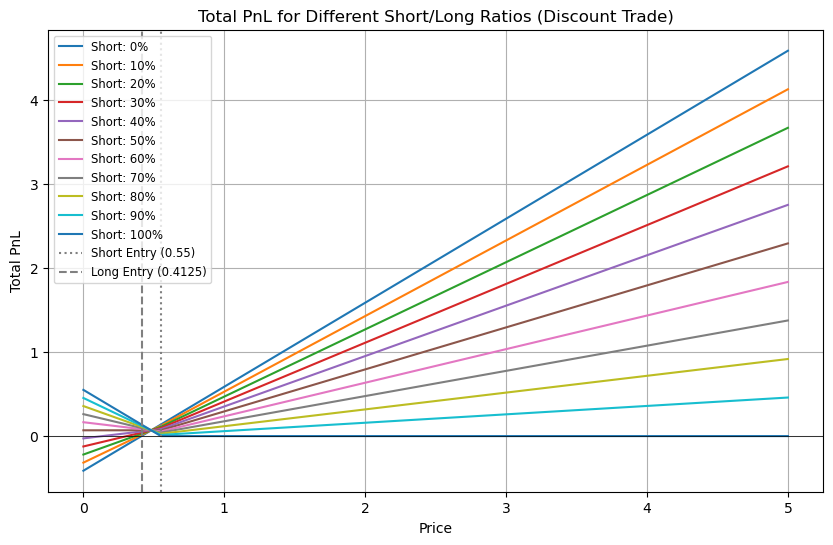

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
prices = np.linspace(0, 5, 1001)  # Prices from 0 to 5
discount = 0.25
entry_short = 0.55              # Market short entry price
entry_long = (1 - discount) * entry_short  # Discounted purchase price (0.4125)

plt.figure(figsize=(10, 6))

# In this structure, you always hold the tokens (100% long)
# and you short a fraction (w_short) of your position.
for w_short in np.arange(0, 1.01, 0.1):
    w_long = 1 - w_short
    # Long PnL (always 100% long)
    long_pnl = w_long * (prices - entry_long)
    # Short PnL is applied only to the fraction that is shorted
    short_pnl = np.maximum(w_short * (entry_short - prices), 0)
    # Total PnL: sum of long and short components
    total_pnl = long_pnl + short_pnl
    
    label_str = f"Short: {w_short*100:.0f}%"
    plt.plot(prices, total_pnl, label=label_str)

# Add vertical lines for entry prices
plt.axvline(entry_short, color='gray', linestyle=':', label='Short Entry (0.55)')
plt.axvline(entry_long, color='gray', linestyle='--', label='Long Entry (0.4125)')
plt.axhline(0, color='black', linewidth=0.5)
plt.title('Total PnL for Different Short/Long Ratios (Discount Trade)')
plt.xlabel('Price')
plt.ylabel('Total PnL')
plt.legend(loc='best', fontsize='small')
plt.grid(True)
plt.show()


The first objective therefore is to find the optimal short % that will allow us to capture the most upside, while also capping our exposure to the downside. In order to do that, let us initially analyze the payoff structure of both legs for 50% short ratio (the one we did with AVAX).

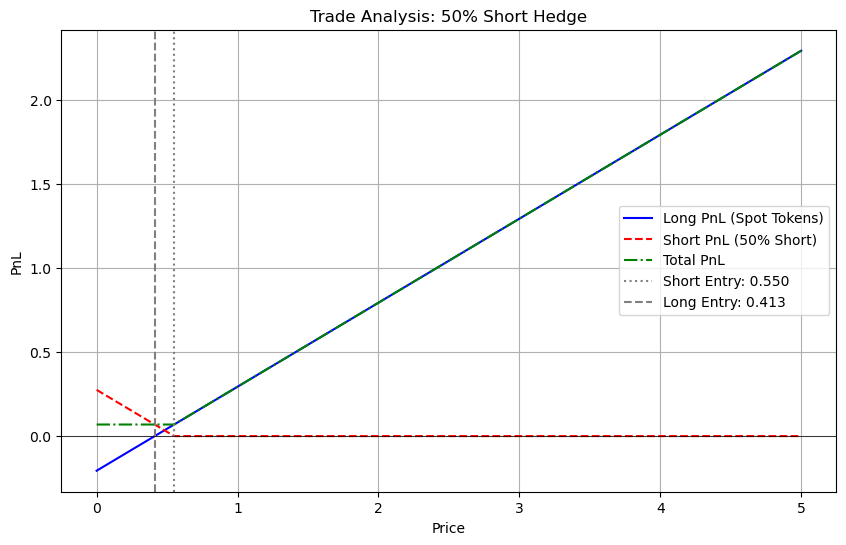

Minimum Total PnL: 0.06874999999999998
Maximum Total PnL: 2.29375


In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
prices = np.linspace(0, 5, 1001)  # Price range from 0 to 5
discount = 0.25
entry_short = 0.55              # Market price for the short entry
entry_long = (1 - discount) * entry_short  # Discounted purchase price, e.g., 0.4125
w_short = 0.5 # 50% short hedge
w_long = 1 - w_short

# Calculate each leg's PnL:
long_pnl = w_long * (prices - entry_long)
short_pnl = np.maximum(entry_short - prices, 0) * w_short
total_pnl = long_pnl + short_pnl

# Plotting the legs and the total PnL
plt.figure(figsize=(10, 6))
plt.plot(prices, long_pnl, label='Long PnL (Spot Tokens)', linestyle='-', color='blue')
plt.plot(prices, short_pnl, label='Short PnL (50% Short)', linestyle='--', color='red')
plt.plot(prices, total_pnl, label='Total PnL', linestyle='-.', color='green')

# Add vertical lines for entry prices:
plt.axvline(entry_short, color='gray', linestyle=':', linewidth=1.5, label=f'Short Entry: {entry_short:.3f}')
plt.axvline(entry_long, color='gray', linestyle='--', linewidth=1.5, label=f'Long Entry: {entry_long:.3f}')
plt.axhline(0, color='black', linewidth=0.5)
plt.title('Trade Analysis: 50% Short Hedge')
plt.xlabel('Price')
plt.ylabel('PnL')
plt.legend(loc='best')
plt.grid(True)
plt.show()
print("Minimum Total PnL:", np.min(total_pnl))
print("Maximum Total PnL:", np.max(total_pnl))

As we can see in the chart, hedging 50% at t0, we "fix" that the trade will always be profitable as long as we can settle the spot tokens and the short perp. But this is not necessarily the best approach as it can be capital intensive, expose us unnecessarily to funding rates, and, perhaps most importantly, it is suboptimal wrt capturing the upside. So we need to find a better payoff structure. We will do that by solving for an unknown short % that will be subject to two constraints: a) minimum PnL will be 0, and b) it will have higher maximum PnL than the 50% short ratio structure.

Optimal w_short (for min PnL = 0): 0.375
Optimal w_long: 0.625


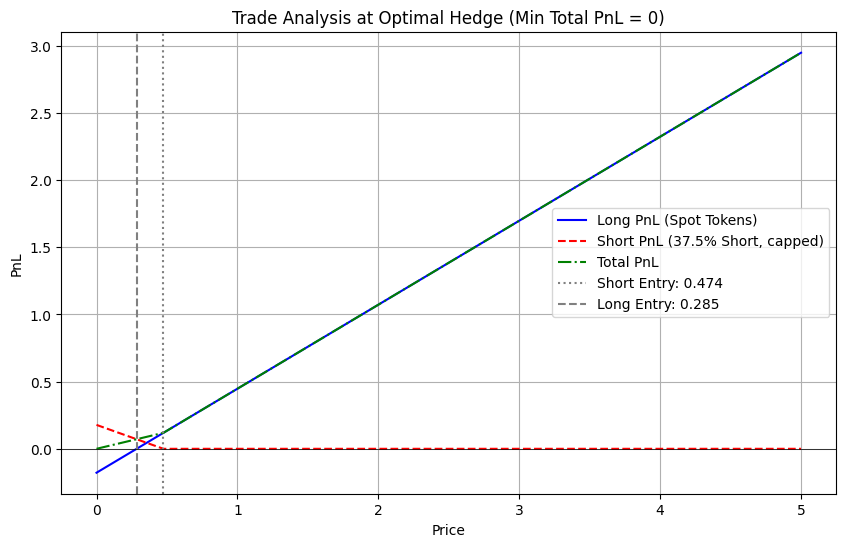

Minimum Total PnL: 2.7755575615628914e-17
Maximum total PnL: 2.9470625


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq

# Parameters
discount = 0.4
entry_short = 0.4745                        
entry_long = (1 - discount) * entry_short    

# Function for total PnL at price=0 (worst-case)
def total_pnl_at_zero(w_short):
    return w_short * entry_short - (1 - w_short) * entry_long

# Use scipy.optimize.brentq to find w_short numerically
optimal_w_short = brentq(total_pnl_at_zero, 0, 1)
optimal_w_long = 1 - optimal_w_short

print("Optimal w_short (for min PnL = 0):", optimal_w_short)
print("Optimal w_long:", optimal_w_long)

# Plotting PnL at optimal weights
prices = np.linspace(0, 5, 1001)  

long_pnl = optimal_w_long * (prices - entry_long)
short_pnl = np.maximum(entry_short - prices, 0) * optimal_w_short
total_pnl = long_pnl + short_pnl

plt.figure(figsize=(10, 6))
plt.plot(prices, long_pnl, label='Long PnL (Spot Tokens)', linestyle='-', color='blue')
plt.plot(prices, short_pnl, label=f'Short PnL ({optimal_w_short*100:.1f}% Short, capped)', linestyle='--', color='red')
plt.plot(prices, total_pnl, label='Total PnL', linestyle='-.', color='green')
plt.axvline(entry_short, color='gray', linestyle=':', linewidth=1.5, label=f'Short Entry: {entry_short:.3f}')
plt.axvline(entry_long, color='gray', linestyle='--', linewidth=1.5, label=f'Long Entry: {entry_long:.3f}')
plt.axhline(0, color='black', linewidth=0.5)
plt.title('Trade Analysis at Optimal Hedge (Min Total PnL = 0)')
plt.xlabel('Price')
plt.ylabel('PnL')
plt.legend(loc='best')
plt.grid(True)
plt.show()
print("Minimum Total PnL:", np.min(total_pnl))
print("Maximum total PnL:", np.max(total_pnl))

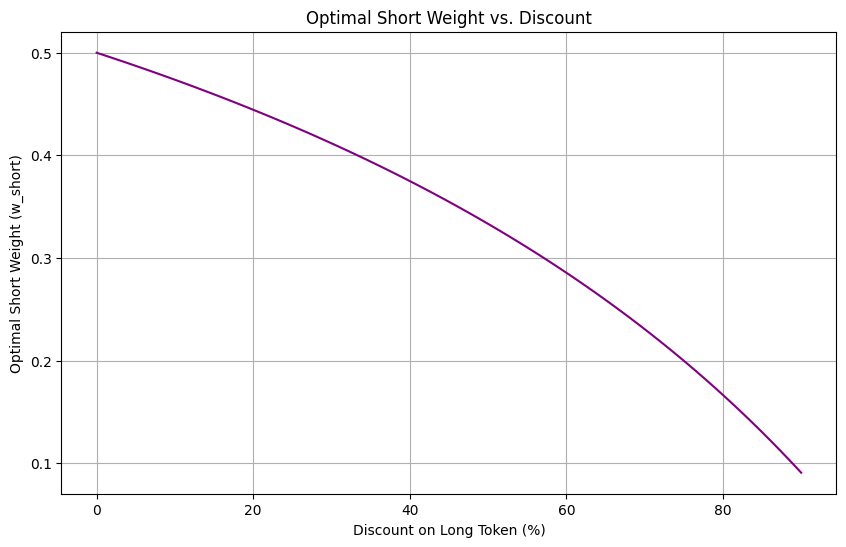

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq

# Fixed short entry price - here JUP price, but can be anything for the simulation
entry_short = 0.4745

# Discount range (e.g., from 0% to 90%)
discounts = np.linspace(0, 0.9, 100)
optimal_w_shorts = []

# Define function to compute optimal w_short at a given discount
def find_optimal_w_short(discount):
    entry_long = (1 - discount) * entry_short

    def total_pnl_at_zero(w_short):
        return w_short * entry_short - (1 - w_short) * entry_long

    return brentq(total_pnl_at_zero, 0, 1)

# Calculate optimal short weight for each discount
for d in discounts:
    w_short = find_optimal_w_short(d)
    optimal_w_shorts.append(w_short)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(discounts * 100, optimal_w_shorts, color='purple')
plt.title("Optimal Short Weight vs. Discount")
plt.xlabel("Discount on Long Token (%)")
plt.ylabel("Optimal Short Weight (w_short)")
plt.grid(True)
plt.show()


By lowering the initial short ratio by 7,14%, we can capture larger upside, while still limiting the worst outcome of the trade to 0 (which would happen only if prices went to 0, which means we can do this exercise also with some pre-defined "floor price", which we believe the prices will not get below and optimize for that). Lowering the amount shorted at t0 has more benefits than just capturing the upside (obviously this strategy fits well only for tokens we are bullish on, if we buy shitcoins, we should reverse it and show our bias that way) - the lower quantity we short, the less we are exposed to funding rates and the less capital we need to hold on the CEX. We have shown the simulation of this for a different discounts - as expected, the larger the discount, the less we need to short in order to fix PnL at 0.

In line with this, the second goal of this sizing exercise will be to find some heuristic that will allow us to adjust the initial sizing based on the historical funding rates..

## Sizing with funding rates (Work in progress)

There are multiple approaches to account for the impact of funding rates on the payoff structure of perpetual futures. A simple and effective way is to **deterministically calculate a funding rate factor**, which adjusts the payoff based on the average annual funding rate and the holding period of the trade. This factor is calculated using compound interest as follows:


Funding Factor = (1 + r)^T


Where:

- \( r \) = Mean annual funding rate (negative if you pay funding, positive if you receive funding).
- \( T \) = Holding period in years (e.g., 1.0 for one year).

The interpretation of the `funding_factor` is:

- Exactly **1.0** if the funding rate is zero.
- Between **0 and 1** if funding rates are negative (indicating you pay funding to maintain the short position).
- Greater than **1.0** if funding rates are positive (indicating you earn funding from the short position).

Once calculated, the funding cost of the short position is determined as:


Funding Cost = Weight Short * (Funding Factor - 1)


This expression essentially takes the notional of the short position (represented by `weight_short` for 1 unit of exposure) and adjusts it by the impact of the funding factor.


Deterministic compound funding factor: 0.5120000000000001


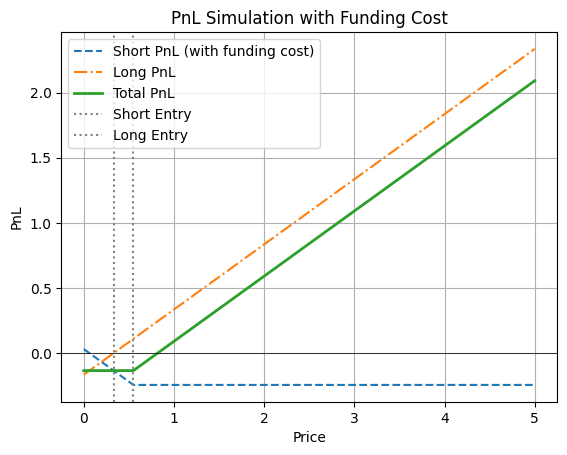

Minimum Total PnL: -0.13399999999999995
Maximum Total PnL: 2.091


In [4]:
import numpy as np
import matplotlib.pyplot as plt

def compute_funding_factor(annual_rate_percent, period_fraction, compounding="compound"):
    """
    Computes the funding factor using compound interest.
    
    Parameters:
      annual_rate_percent: Annual funding rate as a percentage (e.g., -10 for -10% p.a.)
      period_fraction: The holding period in years (e.g., 22/12 for 22 months)
      compounding: Use 'compound' for compound interest.
      
    Returns:
      The funding multiplier factor.
    """
    r = annual_rate_percent / 100.0  # Convert percentage to decimal.
    if compounding == "compound":
        factor = (1 + r) ** period_fraction
    else:
        factor = 1 + r * period_fraction
    return factor

# Parameters for funding cost.
annual_rate = -20        # -10% per annum funding rate.
period_fraction = 36/12    # 22 months expressed in years.
funding_factor = compute_funding_factor(annual_rate, period_fraction, compounding="compound")
print("Deterministic compound funding factor:", funding_factor)

# Strategy parameters.
discount = 0.4
entry_short = 0.55                         
entry_long = (1 - discount) * entry_short                   # Long position entry price.
weight_short = 0.5          # 50% of total capital allocated to the short.
weight_long = 1- weight_short                  # 50% allocated to the long.

# Raw PnL from the short position based solely on the price move.
# Since the short is hedged by spot, we cap the downside to 0.
short_raw_pnl = np.maximum(entry_short - prices, 0) * weight_short

# Funding cost is calculated on the initial notional.
# With a funding factor less than 1, the cost is:
# funding_cost = notional * (funding_factor - 1)
funding_cost = weight_short * (funding_factor - 1)

# The net short PnL is the raw PnL plus the funding cost.
# This means that even if the price move generates no profit (raw pnl is 0),
# the short position will still lose money equal to the funding cost.
short_pnl = short_raw_pnl + funding_cost

# Long position PnL is simply the difference between current price and entry.
long_pnl = (prices - entry_long) * weight_long

# Total PnL is the sum of both positions.
total_pnl = short_pnl + long_pnl

# Plot the results.
plt.plot(prices, short_pnl, label='Short PnL (with funding cost)', linestyle='--')
plt.plot(prices, long_pnl, label='Long PnL', linestyle='-.')
plt.plot(prices, total_pnl, label='Total PnL', linewidth=2)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(entry_short, color='gray', linestyle=':', label='Short Entry')
plt.axvline(entry_long, color='gray', linestyle=':', label='Long Entry')
plt.title('PnL Simulation with Funding Cost')
plt.xlabel('Price')
plt.ylabel('PnL')
plt.legend()
plt.grid(True)
plt.show()
print("Minimum Total PnL:", np.min(total_pnl))
print("Maximum Total PnL:", np.max(total_pnl))